In [2]:
import numpy as np
from wLSM_utils import *
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed as ASE
from graspy.cluster import GaussianCluster as GCLUST
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import adjusted_rand_score as ari

%matplotlib inline
from itertools import combinations
from scipy.stats import norm
import scipy.optimize as optimize

# %matplotlib inline

In [3]:
def generate_cyclops(X, n, pi, density=None, density_params=[0,1], acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    counts = np.random.multinomial(n, [pi, 1 - pi]).astype(int)
    
    if density is None:
        density = np.random.uniform
        U = sample(counts[0], density, density_params)
        X_L = get_latent_positions(U)
    else:
#         U = sample(counts[0], density, density_params)
        density_params = np.array(density_params)
        d = len(density_params)
        if density_params.ndim == 1:
            pass
        else:
            X_temp = np.stack([sample(counts[0], density, density_params[i]) for i in range(d)], axis=1)
            quad = np.sum(np.array([3, 3])*X_temp[:,:2]**2, axis=1)[:, np.newaxis]
            print(quad, X_temp[0, 0], X_temp[0, 1], X_temp[0, 0]**2 + X_temp[0, 1]**2)
            X_L = np.concatenate((X_temp[:,:2], quad), axis=1)
        
    X = X[:, np.newaxis].T
    
    All_X = np.concatenate((X_L, X), axis = 0)
    
    P = All_X @ All_X.T
    
    A = sbm(np.concatenate((np.ones(counts[0]).astype(int), [counts[1]])), P)
    
    return A, counts

In [4]:
X = np.array([0.2, 0.2, 0.2])
density = np.random.uniform
density_params = np.array([[0.3, 0.4],[0.3, 0.35]])

n = 1000
pi = 0.9

A, counts = generate_cyclops(X, n, pi, None)
c = [0]*counts[0]
c += [1]*counts[1]

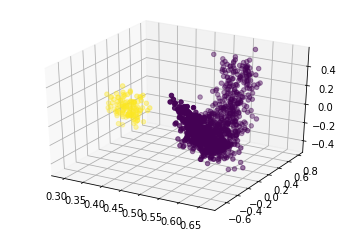

In [5]:
ase = ASE(n_components=3)
X_hat = ase.fit_transform(A)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=c)
# ax.scatter(A[:, 0], A[:, 1], A[:, 2])#, c=c)

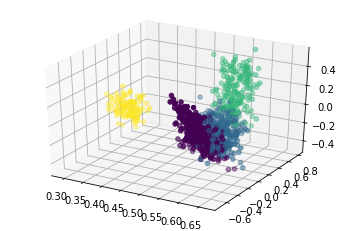

In [6]:
gclust = GCLUST(max_components=4)
c_hat = gclust.fit_predict(X_hat)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=c_hat)

In [7]:
def quadratic(data, params):
    if data.ndim == 1:
        sum_ = np.sum(data[:-1]**2 * params[:-1]) + params[-1]
        return sum_
    elif data.ndim == 2:
        sums = np.sum(data[:, :-1]**2 * params[:-1], axis = 1) + params[-1]
        return sums
    else:
        raise ValueError("unsuppored data")
        
def quadratic_log_likelihood(data, params, curve_density=False):
    n, d = data.shape
    fitted_Z = quadratic(data, params)
    residuals = fitted_Z - data[:, -1] # assuming data.ndim == 2
    std = np.std(residuals, ddof=1)
    
    log_likelihood = 0
    for i in range(n):
        log_likelihood += np.log(norm.pdf(residuals[i], fitted_Z[i], std))
        
    if curve_density:
        log_A = 0
    else:
        maxes = np.array([max(data[:, i]) for i in range(data.shape[1] - 1)])
        mins = np.array([min(data[:, i]) for i in range(data.shape[1] - 1)])
        area = np.prod(maxes - mins)
        log_A = temp_n * np.log(1/area)
        
    return log_likelihood + log_A

def func(data, a, b, c):
    if data.ndim == 1:
        return a*(data[0])**2 + b*data[1]**2 + c
    return a*(data[:, 0])**2 + b*data[:, 1]**2 + c

def monte_carlo_integration(data, func, params, M, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = data.shape
    
    maxes = np.array([max(data[:, i]) for i in range(d-1)])
    mins = np.array([min(data[:, i]) for i in range(d-1)])
    area = np.prod(maxes - mins)
    
    sample = np.zeros((M, d-1))
    
    for coord in range(d-1):
        sample[:, coord] = np.random.uniform(mins[coord], maxes[coord])
        
    sum_f = 0
    for it in range(M):
        sum_f += func(sample[it, :], params[0], params[1], params[2])
        
    estimated_integral = (area)*(1/M)*sum_f
    
    return estimated_integral

In [45]:
unique_labels = np.unique(c_hat)
K = len(unique_labels)
M = 10**8

class_idx = np.array([np.where(c_hat == u)[0] for u in unique_labels])

loglikelihoods = [np.sum(gclust.model_.score_samples(X_hat))]
combos = [None]
aris = [ari(c, c_hat)]
bic = [gclust.model_.bic(X_hat)]

n, d = X_hat.shape

# Plot for each fitted quad
for k in range(len(unique_labels)):
    for combo in list(combinations(np.unique(c_hat), k+1)):
        combo = np.array(list(combo)).astype(int)
        combos.append(combo)
        
        print(combo)
        
        temp_quad_labels = np.concatenate(class_idx[combo])
        temp_n = len(temp_quad_labels)
        temp_K = K - len(combo)
        temp_mean_params = temp_K * d
        temp_cov_params = temp_K * d * (d + 1) / 2
        temp_quad_params = (d - 1)*2 + d - 1 + (d - 1) * (d - 2) / 2 + 1
        temp_n_params = temp_mean_params + temp_cov_params
        temp_n_params = temp_quad_params + temp_K - 1
        
        temp_label = min(combo)
        temp_c_hat = c_hat.copy()
        temp_c_hat[temp_quad_labels] = temp_label
        
        params, pcov = optimize.curve_fit(func, X_hat[temp_quad_labels, :2], X_hat[temp_quad_labels, 2])
        
        integral = monte_carlo_integration(X_hat[temp_quad_labels], func, params, M)
        temp_density = 1/integral
        
        quad_log_likelihood = quadratic_log_likelihood(X_hat[temp_quad_labels], params, curve_density=False)
        quad_log_likelihood += temp_n * np.log(temp_density)
        gmm_log_likelihood = np.sum(gclust.model_.score_samples(X_hat[-temp_quad_labels]))
        
        loglikelihoods.append(quad_log_likelihood + gmm_log_likelihood)
        aris.append(ari(c, temp_c_hat))
        bic.append(2*gmm_log_likelihood*(n - temp_n) + 2*quad_log_likelihood*temp_n -
                        temp_n_params * np.log(n))

[0]


KeyboardInterrupt: 

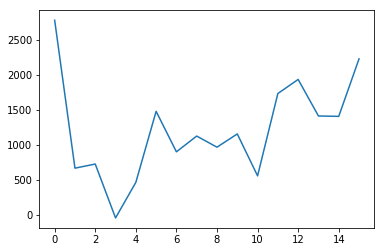

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), loglikelihoods)

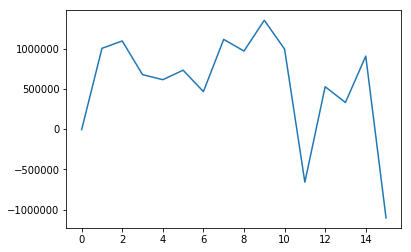

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), bic)

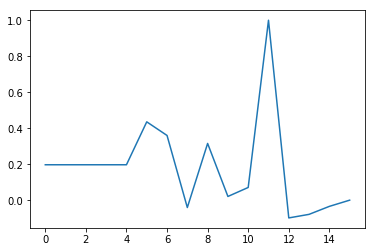

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), aris)

Text(0.5, 1.0, 'Clustering with best ARI')

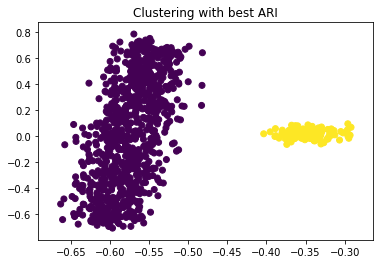

In [12]:
combo = combos[np.argmax(aris)]
temp_quad_labels = np.concatenate(class_idx[combo])
temp_label = min(combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat.copy()
temp_c_hat[temp_quad_labels] = temp_label

params, pcov = optimize.curve_fit(func, X_hat[temp_quad_labels, :2], X_hat[temp_quad_labels, 2])

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=temp_c_hat)
ax.set_title('Clustering with best ARI')

Text(0.5, 1.0, 'Original clustering')

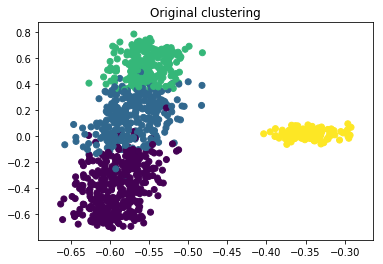

In [13]:
fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=c_hat)
ax.set_title('Original clustering')

Text(0.5, 1.0, 'Clustering with worst BIC')

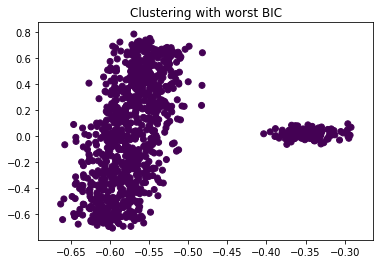

In [14]:
combo = combos[np.argmin(bic)]
temp_quad_labels = np.concatenate(class_idx[combo])
temp_label = min(combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat.copy()
temp_c_hat[temp_quad_labels] = temp_label

params, pcov = optimize.curve_fit(func, X_hat[temp_quad_labels, :2], X_hat[temp_quad_labels, 2])

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=temp_c_hat)
ax.set_title('Clustering with worst BIC')

In [30]:
def monte_carlo_integration(data, func, params, M, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = data.shape
    
    maxes = np.array([max(data[:, i]) for i in range(d-1)])
    mins = np.array([min(data[:, i]) for i in range(d-1)])
    area = np.prod(maxes - mins)
    
    sample = np.zeros((M, d-1))
    
    for coord in range(d-1):
        sample[:, coord] = np.random.uniform(mins[coord], maxes[coord])
        
    sum_f = 0
    for it in range(M):
        sum_f += func(sample[it, :], params[0], params[1], params[2])
        
    estimated_integral = (area)*(1/M)*sum_f
    
    return estimated_integral

In [46]:
import _pickle as pkl
combos = pkl.load(open('combos_cyclops.pkl', 'rb'))
aris = pkl.load(open('aris_cyclops.pkl', 'rb'))
bic = pkl.load(open('bic_cyclops.pkl', 'rb'))
likelihoods = pkl.load(open('loglikelihoods_cyclops.pkl', 'rb'))

Text(0.5, 1.0, 'Clustering with best ARI')

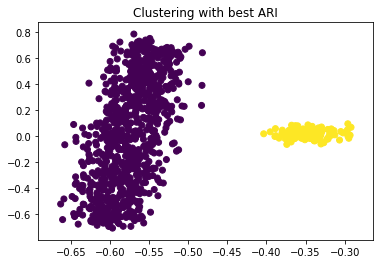

In [47]:
combo = combos[np.argmax(aris)]
temp_quad_labels = np.concatenate(class_idx[combo])
temp_label = min(combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat.copy()
temp_c_hat[temp_quad_labels] = temp_label

params, pcov = optimize.curve_fit(func, X_hat[temp_quad_labels, :2], X_hat[temp_quad_labels, 2])

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=temp_c_hat)
ax.set_title('Clustering with best ARI')

Text(0.5, 1.0, 'Original clustering')

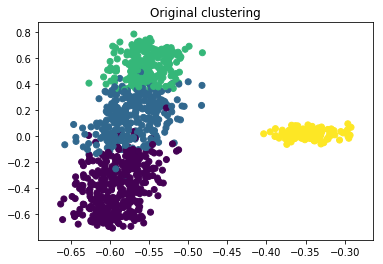

In [48]:
fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=c_hat)
ax.set_title('Original clustering')

Text(0.5, 1.0, 'Clustering with best BIC')

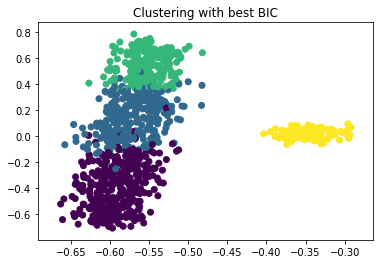

In [52]:
combo = combos[np.argmin(bic)]
temp_quad_labels = np.concatenate(class_idx[combo])
temp_label = min(combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat.copy()
temp_c_hat[temp_quad_labels] = temp_label

params, pcov = optimize.curve_fit(func, X_hat[temp_quad_labels, :2], X_hat[temp_quad_labels, 2])

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat[:, 0], X_hat[:, 1], c=temp_c_hat)
ax.set_title('Clustering with best BIC')